# 거리에 따른 데이터 분석
## airKorea의 pm2.5와 arim의 pm2.5의 값 차이를 통해
## airKorea가 arim 보다 클 때의 특징, 작을 때의 특징을 찾기 위한 페이지

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from matplotlib import font_manager, rc
import warnings

# plt parameter 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['figure.figsize'] = [25,15]
plt.rcParams['font.size'] = 25

# 경고메세지 끄기
warnings.filterwarnings(action='ignore')

In [75]:
# outliar 제거 함수 (IQR 설정) (1)
def remove_out(dataframe, remove_col) :
    dff = dataframe
    for k in remove_col :
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 1.5
        outliar_h = dff[k] >= level_3q + (rev_range * IQR)
        outliar_l = dff[k] <= level_1q - (rev_range * IQR)
        a=dff[outliar_h].index
        b=dff[outliar_l].index
        dff.drop(a, inplace=True)
        dff.drop(b, inplace=True)

# pm25값이 최대인 인덱스를 찾아 빼는 함수, 2번 함수가 잘 적용되는지 확인하기 위한 용도
def find_max_value_pm25(data1, data2) :
    max_index = data1['pm25'].idxmax()
    arim = data1.loc[max_index, 'pm25'] # data1의 max값의 날짜에 맞는 pm25값
    arim_date = max_index # max_index값이 날짜로 설정되어 있으므로
    air = data2.loc[data2.index == arim_date] # data1와 같은 날짜 찾기
    return abs(air.pm25 - arim) # arim data와 air data의 pm25[max]값 차이

# pm10값이 최대인 인덱스를 찾아 빼는 함수, 2번 함수가 잘 적용되는지 확인하기 위한 용도
def find_max_value_pm10(data1, data2) :
    max_index = data1['pm10'].idxmax()
    arim = data1.loc[max_index, 'pm10'] # data1의 max값의 날짜에 맞는 pm25값
    arim_date = max_index # max_index값이 날짜로 설정되어 있으므로
    air = data2.loc[data2.index == arim_date] # data1와 같은 날짜 찾기
    return abs(air.pm10 - arim) # arim data와 air data의 pm25[max]값 차이


#그래프 2개 비교 (차이 비교)
def difference_abs(dataframe1, dataframe2) :    
    diff = abs(np.subtract(dataframe1,dataframe2))
    # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정

    plt.plot(dataframe1.index,diff)
    for i in range(len(dataframe1.index)):
        height = diff[i]
        plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
    plt.title("Difference between airm-airKorea")
    plt.xlabel("Hour")
    plt.ylabel("diff")
    plt.show()

#그래프 2개 비교 (차이 비교) -- 숫자를 표시안함
def difference(dataframe1, dataframe2) :    
    diff = np.subtract(dataframe1,dataframe2)
    # 숫자 넣는 부분, height + 0.25로 숫자 약간 위로 위치하게 조정

    plt.plot(dataframe1.index,diff)
#     for i in range(len(dataframe1.index)):
#         height = diff[i]
#         plt.text(dataframe1.index[i], height + 0.01, '%.2f' %height, ha='center', va='bottom', size = 25)
    plt.title("Difference between airm-airKorea")
    plt.xlabel("Hour")
    plt.ylabel("diff")
    plt.show()
    


# 오차 구해서 그래프로 (dataframe1과 dataframe2는 범위를 설정해야함) dataframe1 = airKorea, dataframe2 = arim (4)
def errorRate(dataframe1, dataframe2) :
    diff = abs(np.subtract(dataframe1, dataframe2))
    result = (diff/dataframe1)*100
    result = result.to_frame(name='errorRate') # series type인 result를 dataframe으로 변환한 후, errorRate 열 추가
    
    # errorRate가 100 이상인 index를 추출하여 호출
    if any(result['errorRate'] >= 100) :
        errorRate100 = result[result['errorRate'] >= 100]['errorRate']
        print(errorRate100)
        print('##########arimData##########')
        print(arim_data_avg.loc[errorRate100.index.tolist()])
        print('##########airKorea Data##########')
        print(airKorea_data_avg.loc[errorRate100.index.tolist()])
    
    plt.plot(dataframe1.index,result['errorRate'])
    for i in range(len(dataframe1.index)):
        height = result.iloc[i]['errorRate']
        plt.text(dataframe1.index[i], height + 0.01, '%.2f %%' %height, ha='center', va='bottom', size = 25)
    plt.title("error rate between airKorea-arim")
    plt.xlabel("Hour")
    plt.ylabel("error rate(%)")
    plt.ylim([0,100])
    plt.show()

# 새로운 함수 -> 이것은 arim data가 airKorea data의 pm2.5보다 크거나 작은 값의 특징을 알아보기 위해 만들었음.
def find_condition(dataframe1, dataframe2) :
    diff = np.subtract(dataframe1.pm25, dataframe2.pm25)
    diff = diff.to_frame(name='difference')

    arimUp = dataframe2.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
    airKoreaUp = dataframe1.loc[diff.loc[diff['difference']>0].index]
    
    arimDown = dataframe2.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
    airKoreaDown = dataframe1.loc[diff.loc[diff['difference']<0].index]

    arimUp.name = 'arimUp'
    arimDown.name = 'arimDown'
    airKoreaUp.name = 'airKoreaUp'
    airKoreaDown.name = 'airKoreaDown'
    
    fig, axes = plt.subplots(2,2, figsize=(50,20))
    cat_features = [arimUp, airKoreaUp, arimDown, airKoreaDown]
    for i, feature in enumerate(cat_features) :
        row = int(i/2)
        col = i%2
        if 'humi' in feature.columns :
            axes[row,col].plot(feature.index,feature.humi)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['humi']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("humi")
            axes[row,col].grid(visible=True)
        else : 
            axes[row,col].plot(cat_features[i-1].index,cat_features[i-1].temp)
            for j in range(len(cat_features[i-1].index)):
                height = cat_features[i-1].iloc[j]['temp']
                axes[row,col].text(cat_features[i-1].index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(cat_features[i-1].name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("temp")
            axes[row,col].grid(visible=True)

# 새로운 함수 -> 이것은 arim data가 airKorea data의 pm2.5보다 크거나 작은 값의 특징을 알아보기 위해 만들었음.
def find_condition_pm25(dataframe1, dataframe2) :
    diff = np.subtract(dataframe1.pm25, dataframe2.pm25)
    diff = diff.to_frame(name='difference')

    arimUp = dataframe2.loc[diff.loc[diff['difference']>0].index] # diff 값이 0보다 큰 즉 airKorea data가 arim보다 큰 값
    airKoreaUp = dataframe1.loc[diff.loc[diff['difference']>0].index]
    
    arimDown = dataframe2.loc[diff.loc[diff['difference']<0].index] # diff 값이 0보다 작은 즉 airKorea data가 arim보다 작은 값
    airKoreaDown = dataframe1.loc[diff.loc[diff['difference']<0].index]

    arimUp.name = 'arimUp'
    arimDown.name = 'arimDown'
    airKoreaUp.name = 'airKoreaUp'
    airKoreaDown.name = 'airKoreaDown'
    
    fig, axes = plt.subplots(2,2, figsize=(50,20))
    cat_features = [arimUp, airKoreaUp, arimDown, airKoreaDown]
    for i, feature in enumerate(cat_features) :
        row = int(i/2)
        col = i%2
        if 'humi' in feature.columns :
            axes[row,col].plot(feature.index,feature.pm25)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['pm25']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("pm25")
            axes[row,col].grid(visible=True)
        else : 
            axes[row,col].plot(feature.index,feature.pm25)
            for j in range(len(feature.index)):
                height = feature.iloc[j]['pm25']
                axes[row,col].text(feature.index[j], height + 0.01, '%.2f ' %height, ha='center', va='bottom', size = 25)
            axes[row,col].set_title(feature.name)
            axes[row,col].set_xlabel("hour")
            axes[row,col].set_ylabel("pm25")
            axes[row,col].grid(visible=True)

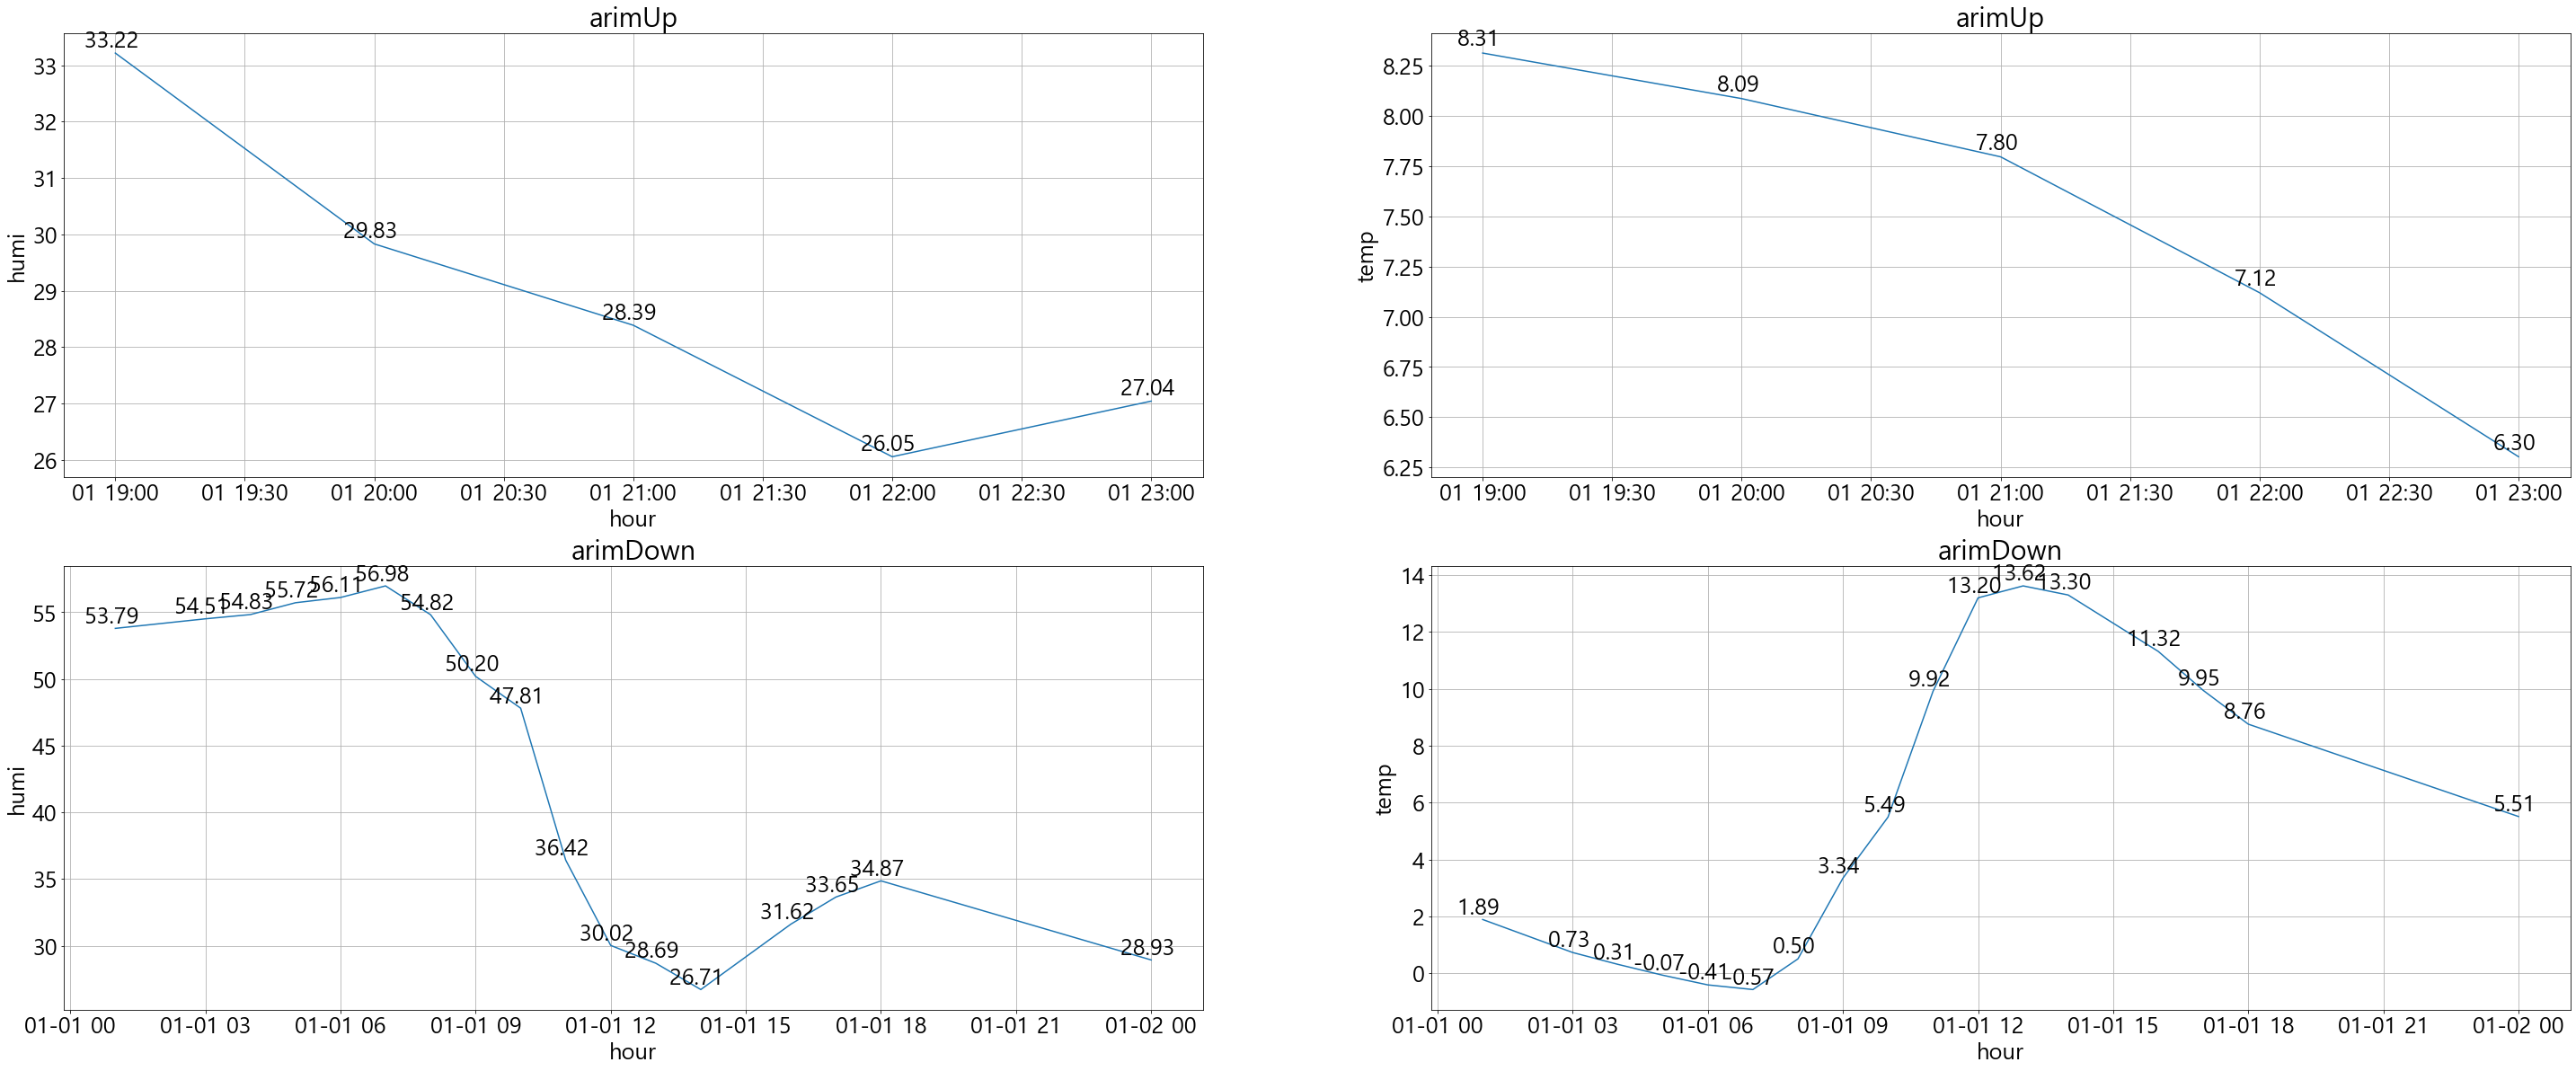

In [76]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

arim_data_avg = arim_data_avg.loc['2023-01-01 01:00:00':'2023-01-02 00:00:00']
airKorea_data_avg = airKorea_data_avg.loc['2023-01-01 01:00:00':'2023-01-02 00:00:00']

find_condition(airKorea_data_avg, arim_data_avg)

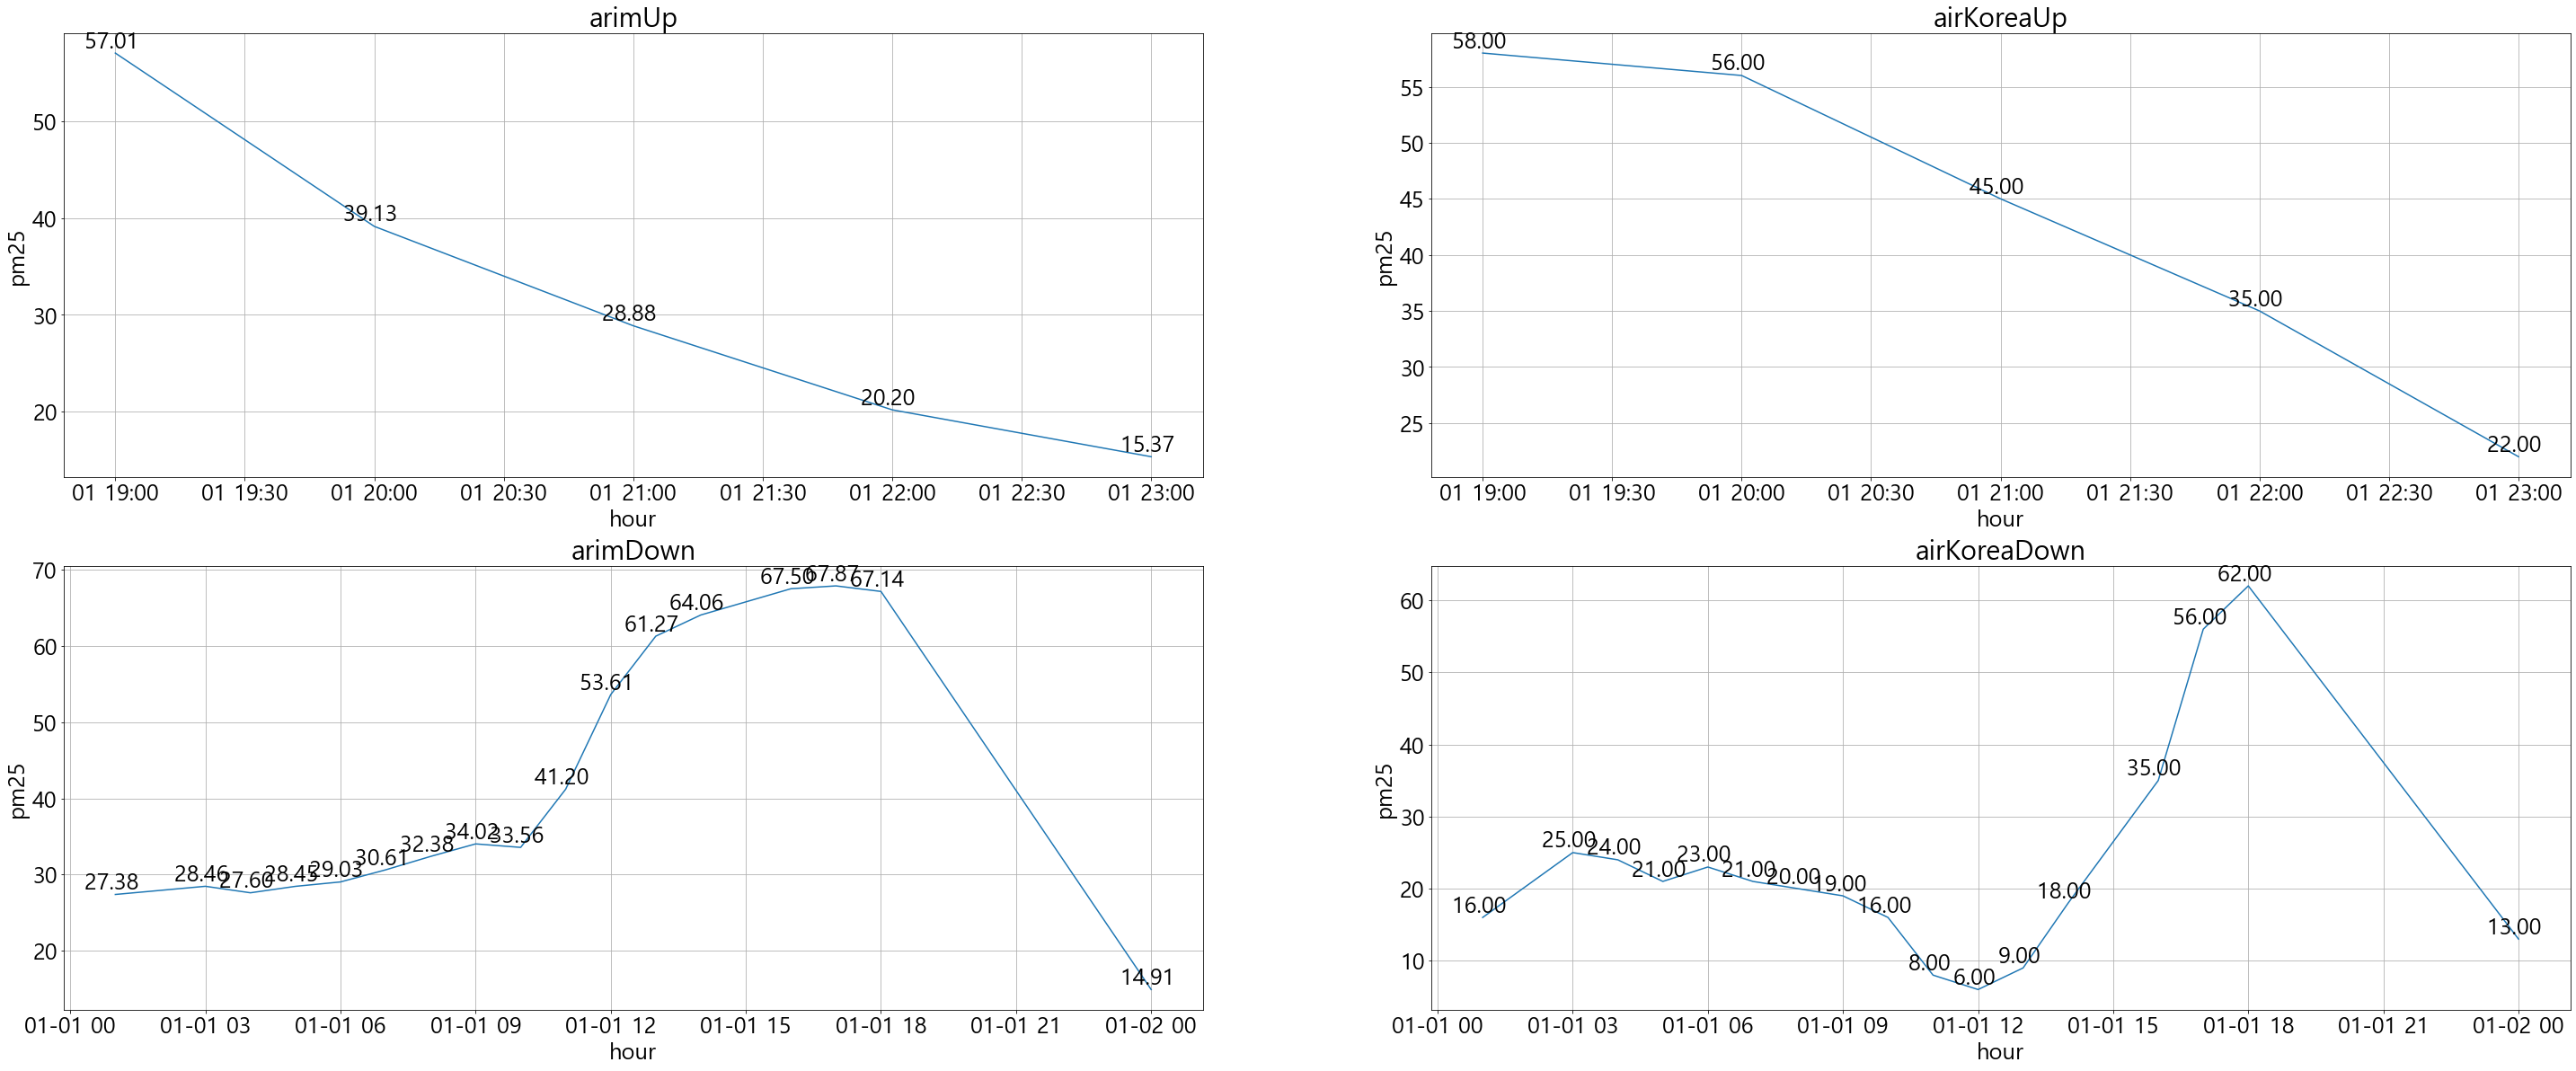

In [74]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')
arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)
# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

arim_data_avg = arim_data_avg.loc['2023-01-01 01:00:00':'2023-01-02 00:00:00']
airKorea_data_avg = airKorea_data_avg.loc['2023-01-01 01:00:00':'2023-01-02 00:00:00']

find_condition_pm25(airKorea_data_avg, arim_data_avg)

# airKorea와 arim pm2.5 전체적인 차이를 확인

# 1.1~1.15

date
2023-01-06 09:00:00    19.921667
Freq: H, Name: pm25, dtype: float64


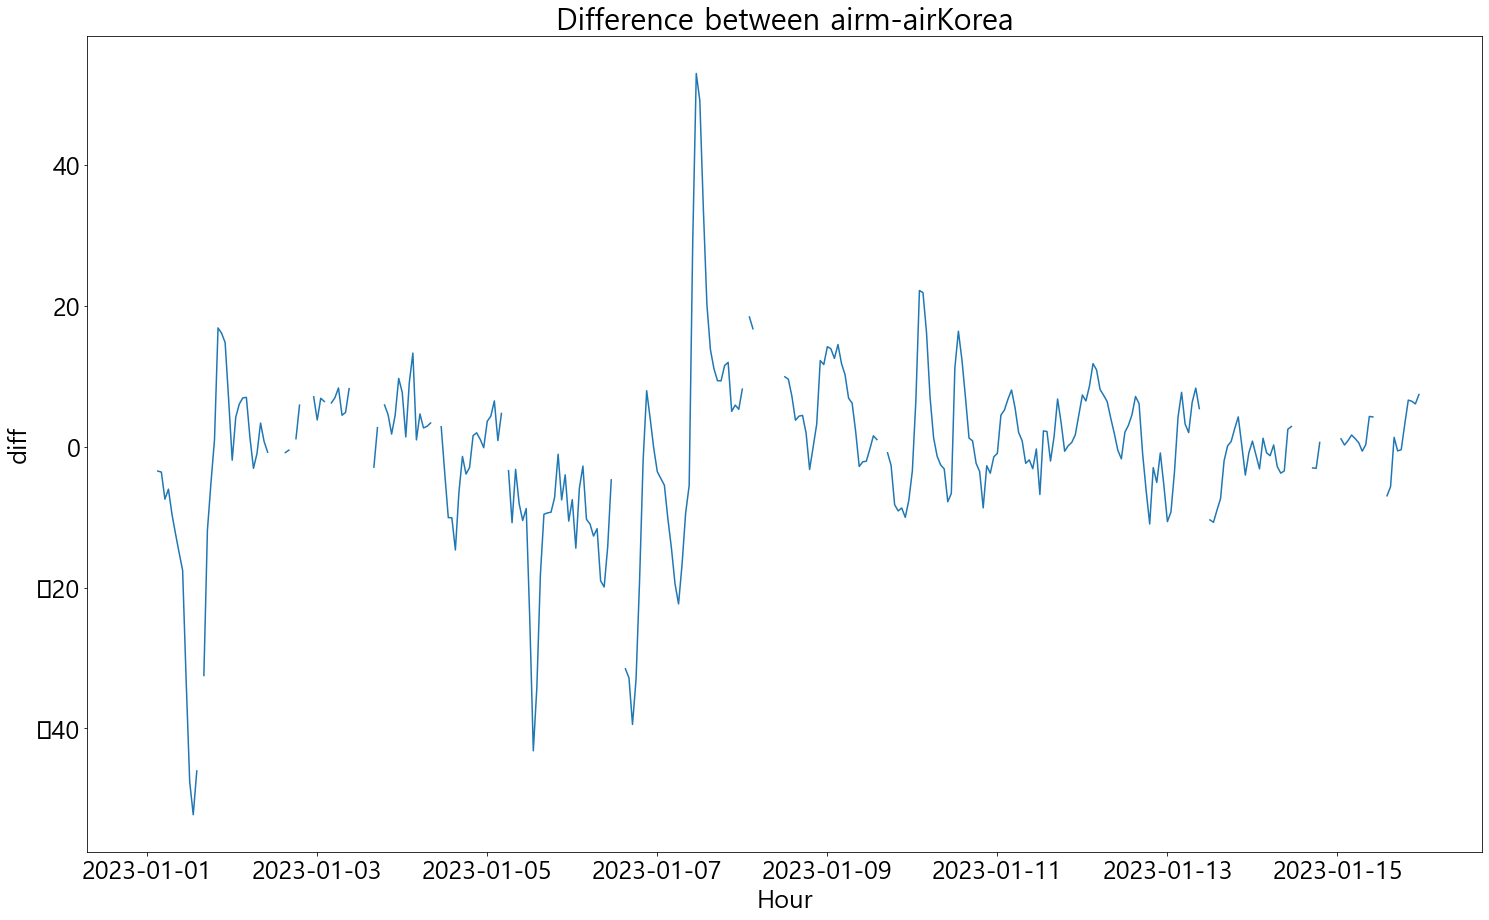

In [57]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 누락 데이터 mean으로 치환 # 치환해서 구해보니.. 더 오차가 커지는 것을 알 수 있음
# mean_pm25 = airKorea_data_avg['pm25'].mean(axis=0)
# airKorea_data_avg['pm25'].fillna(mean_pm25, inplace=True)

# 3번 함수 사용
print(find_max_value_pm25(arim_data_avg, airKorea_data_avg))
# print("구한 평균값", mean_pm25)

difference(airKorea_data_avg.pm25, arim_data_avg.pm25)

In [16]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 누락 데이터 mean으로 치환
# mean_pm25 = airKorea_data_avg['pm25'].mean(axis=0)
# airKorea_data_avg['pm25'].fillna(mean_pm25, inplace=True)

#그래프 2개 비교 (차이 비교)
diff = np.subtract(arim_data_avg['pm25'], airKorea_data_avg['pm25'])
print("diff 절댓값 취하지 않고 평균")
print(diff.mean())
print("diff 절댓값 취하고 평균")
diff = abs(diff)
print(diff.mean())

diff 절댓값 취하지 않고 평균
0.46294309500548114
diff 절댓값 취하고 평균
7.728596093000745


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


date
2023-01-01 10:00:00    109.750000
2023-01-01 11:00:00    415.000000
2023-01-01 12:00:00    793.555556
2023-01-01 13:00:00    580.833333
2023-01-01 14:00:00    255.861111
2023-01-02 06:00:00    307.166667
2023-01-04 13:00:00    251.864407
2023-01-04 14:00:00    201.666667
2023-01-04 15:00:00    244.500000
2023-01-06 15:00:00    175.296296
2023-01-06 16:00:00    113.189655
2023-01-13 12:00:00           inf
2023-01-13 13:00:00    357.944444
2023-01-13 14:00:00    300.111111
2023-01-13 15:00:00    184.375000
2023-01-14 17:00:00    150.750000
2023-01-14 18:00:00    153.333333
2023-01-15 14:00:00    139.366667
Name: errorRate, dtype: float64
##########arimData##########
                               no       pm25       pm10       temp       humi
reg_date                                                                     
2023-01-01 10:00:00  9.390477e+05  33.560000  33.861667   5.490000  47.810000
2023-01-01 11:00:00  9.401833e+05  41.200000  41.886667   9.916667  36.423333
2023-01-01

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

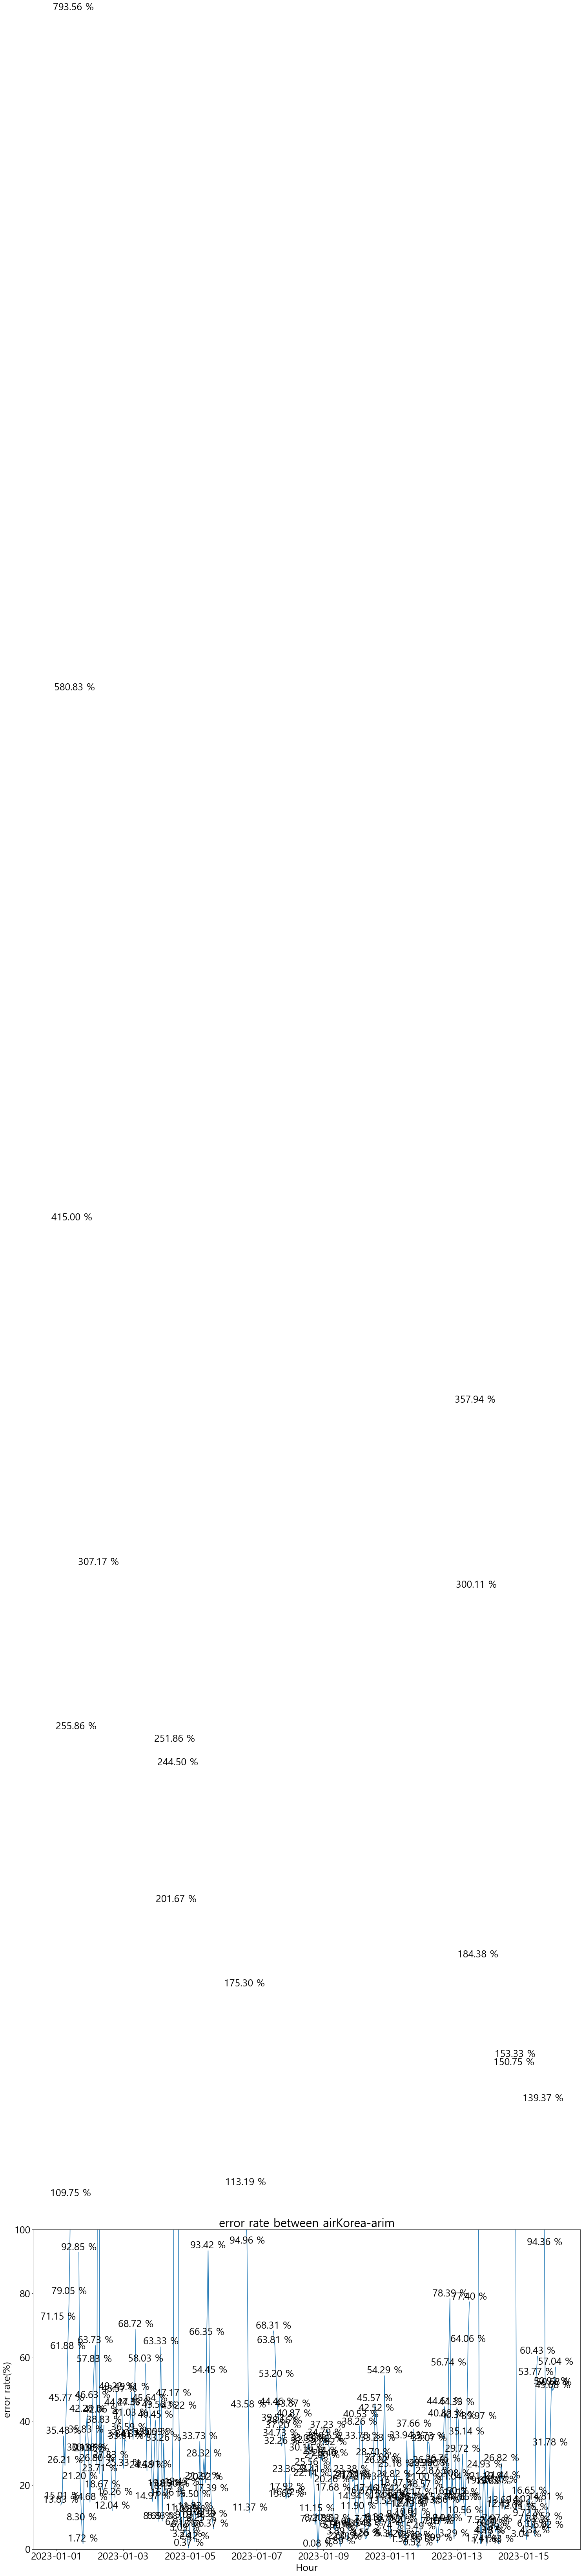

In [70]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

remove_out(arim_data, ['pm25'])

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')
airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)

remove_out(airKorea_data, ['pm25'])

airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

errorRate(airKorea_data_avg.pm25, arim_data_avg.pm25)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


date
2023-01-01 10:00:00    109.750000
2023-01-01 11:00:00    415.000000
2023-01-01 12:00:00    793.555556
2023-01-01 13:00:00    580.833333
2023-01-01 14:00:00    255.861111
2023-01-02 06:00:00    307.166667
Name: errorRate, dtype: float64
##########arimData##########
                                no       pm25       pm10       temp       humi
reg_date                                                                      
2023-01-01 10:00:00  939047.716667  33.560000  33.861667   5.490000  47.810000
2023-01-01 11:00:00  940183.266667  41.200000  41.886667   9.916667  36.423333
2023-01-01 12:00:00  941322.500000  53.613333  55.406667  13.201667  30.021667
2023-01-01 13:00:00  942458.750000  61.275000  64.178333  13.621667  28.688333
2023-01-01 14:00:00  943595.383333  64.055000  68.053333  13.301667  26.715000
2023-01-02 06:00:00  960733.316667   4.071667   4.145000   5.261667  16.591667
##########airKorea Data##########
                     pm10  pm25
date                           


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


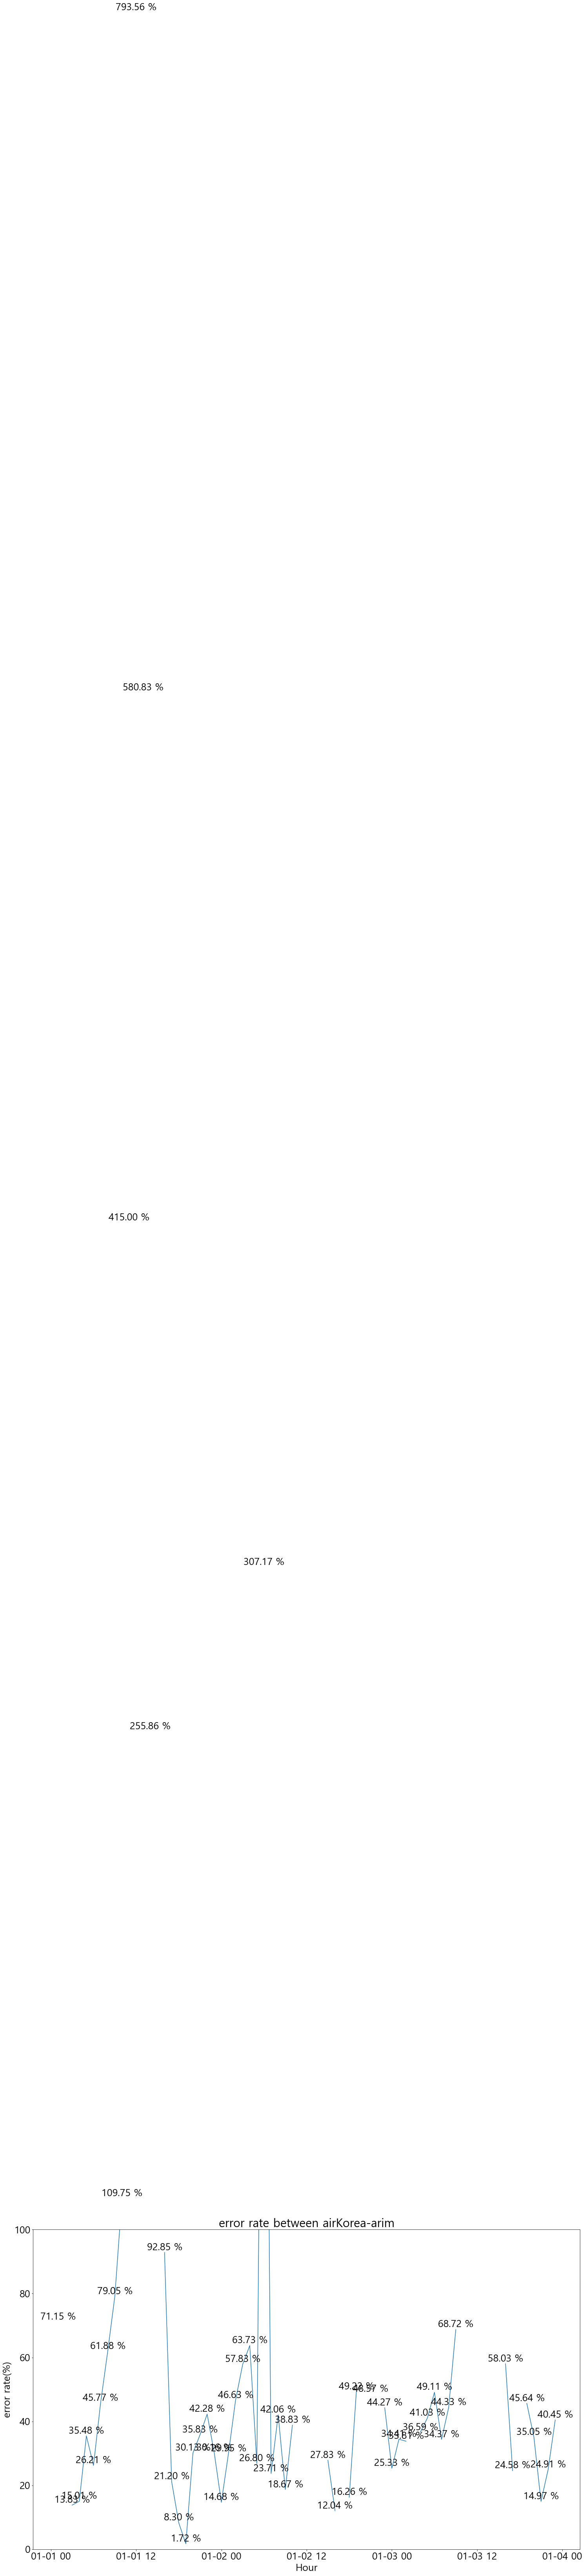

In [69]:
# arim_data 1.1~1.15 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.01~01.15.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

# 함수 1 사용
remove_out(arim_data, ['pm25'])

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.1~1.15 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.01~01.15.csv')
airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)

# 함수 1 사용
remove_out(airKorea_data, ['pm25'])

airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

arim_data_avg_set1= arim_data_avg.loc['2023-01-01 01:00:00':'2023-01-03 23:00:00'].pm25
airKorea_data_avg_set1 = airKorea_data_avg.loc['2023-01-01 01:00:00':'2023-01-03 23:00:00'].pm25

# 함수 4 사용
errorRate(airKorea_data_avg_set1, arim_data_avg_set1)

# 1.16~1.31

date
2023-01-24    17.021667
Freq: H, Name: pm25, dtype: float64


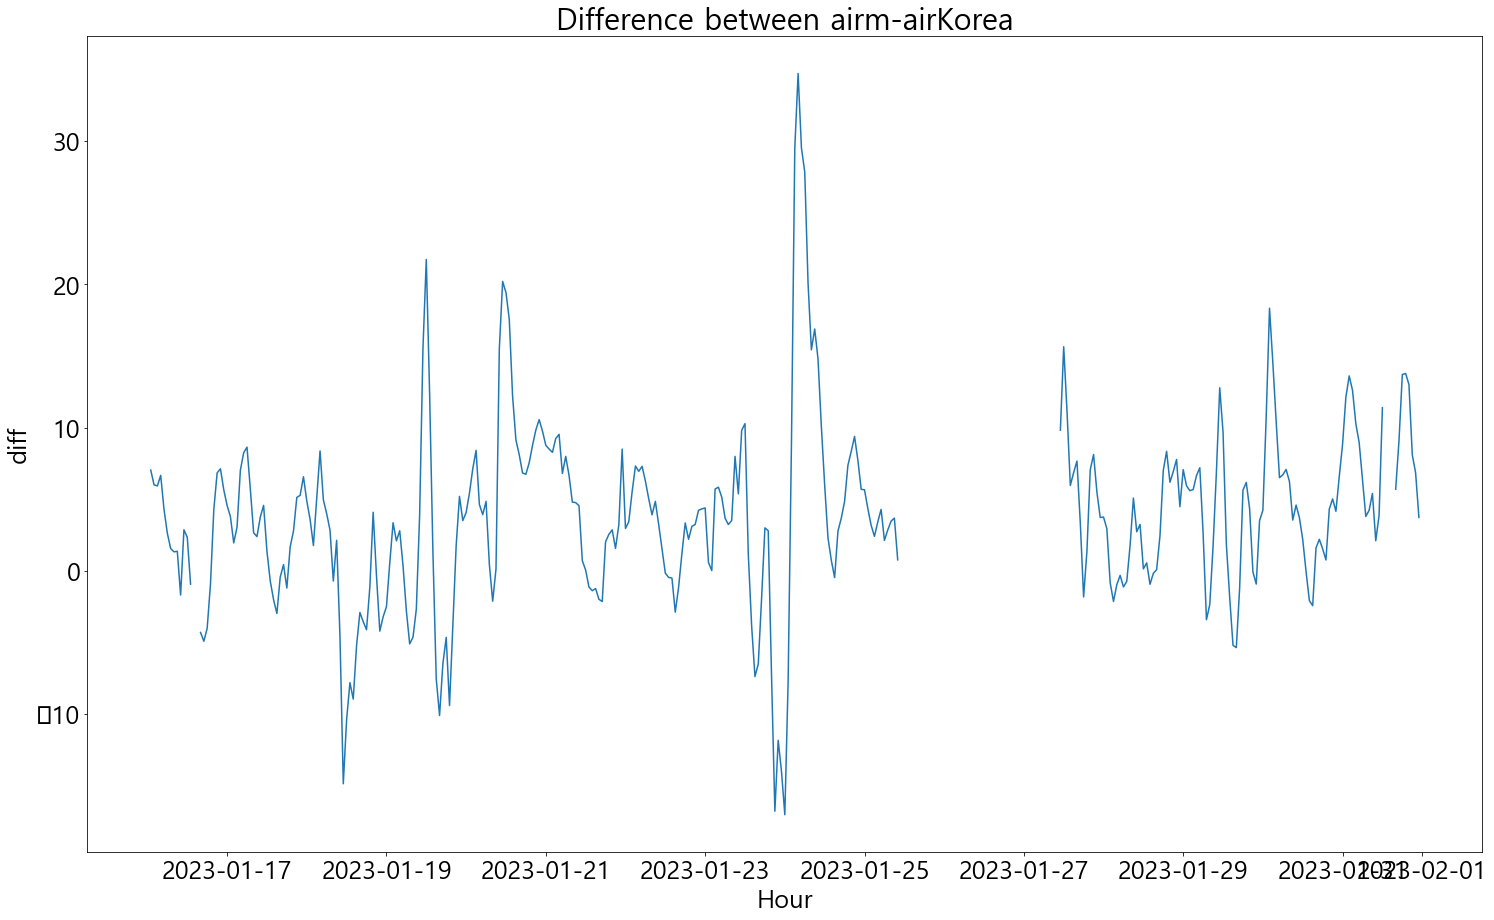

In [60]:
# arim_data 1.16~1.31 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.16~01.31.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.16~1.31 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.16~01.31.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()


# 누락 데이터 mean으로 치환
# mean_pm25 = airKorea_data_avg['pm25'].mean(axis=0)
# airKorea_data_avg['pm25'].fillna(mean_pm25, inplace=True)


# 3번 함수 사용
print(find_max_value_pm25(arim_data_avg, airKorea_data_avg))

difference(airKorea_data_avg.pm25, arim_data_avg.pm25)

In [18]:
# arim_data 1.16~1.31 Hour
arim_data = pd.read_csv('./OA200_2/OA2002_01.16~01.31.csv')

arim_data['reg_date'] = arim_data.reg_date.apply(pd.to_datetime)

# 날짜별 그룹화하고 그 날짜별 시간대별로 다시 그룹화하여 평균값 계산
arim_data_avg = arim_data.groupby([pd.Grouper(key='reg_date', freq='H')]).mean()


# airKorea_data 1.16~1.31 Hour
airKorea_data = pd.read_csv('./AirKorea_상봉동/AirKorea_01.16~01.31.csv')

airKorea_data['date'] = airKorea_data.date.apply(pd.to_datetime)
airKorea_data_avg = airKorea_data.groupby([pd.Grouper(key='date', freq='H')]).mean()

# 누락 데이터 mean으로 치환
# mean_pm25 = airKorea_data_avg['pm25'].mean(axis=0)
# airKorea_data_avg['pm25'].fillna(mean_pm25, inplace=True)


#그래프 2개 비교 (차이 비교)
diff = np.subtract(arim_data_avg['pm25'], airKorea_data_avg['pm25'])
print("diff 절댓값 취하지 않고 평균")
print(diff.mean())
print("diff 절댓값 취하고 평균")
diff = abs(diff)
print(diff.mean())

diff 절댓값 취하지 않고 평균
-3.8359520668741034
diff 절댓값 취하고 평균
5.651270918747604


### pm2.5 기준
- 0~15 ug/m^3 좋음
- 16~35 ug/m^3 보통
- 36~75ug/m^3 나쁨
- 76ug/m^3 이상 매우 나쁨

### airKorea 누락 데이터 평균으로 해서 구해보니 오차가 더 커짐